# Within-NL segment class analysis
UMAP on NL segments to determine whether there is any within-class variation that can be described by the labelled predictors. 
Here, we run the UMAP and evaluation of the projection will take place in a separate notebook.

### Load dataframe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.utils.paths import DATA_DIR, ensure_dir
from avgn.visualization.projections import scatter_spec

In [4]:
from scipy.stats import kruskal

In [5]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [6]:
DATASET_ID = "git_repos"

In [7]:
DT_ID = '2022-03-04_18-41-29'

In [9]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_umap_combinedtidied.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]",DS,DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]",SH,DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]",DS,DS-SH-DS,DS-SH-DS SH-LH


In [11]:
len(seg_df)

1333

In [12]:
seg_df = seg_df.loc[(seg_df["comb_labels"]=="NL")]
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
3,0.338289,0.439778,NL,26,0.338289,0.439778,NLSHDS,0.338289,0,11,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Excitement 2 170519 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[6.8550377, 4.258869]",NL,NL-SH-DS,DS-SH-DS NL-SH-DS
0,0.020744,0.165861,NL,29,0.020744,0.165861,NLDS,0.020744,0,12,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MGGY Alarm Alert series 1 100717,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.7238226, 4.309696]",NL,NL-DS,NL-DS DS-SH-DS SH-LH
3,0.349618,0.443789,NL,51,0.349618,0.443789,NLSHDS,0.349618,0,20,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MGGY Alert 2 070817,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6222105, 5.2053003]",NL,NL-SH-DS,DS-SH-DS NL-SH-DS SH-DS LH


In [14]:
seg_df.sort_values(by=['ID'], inplace=True)

In [16]:
len(seg_df)

173

BMYO 10


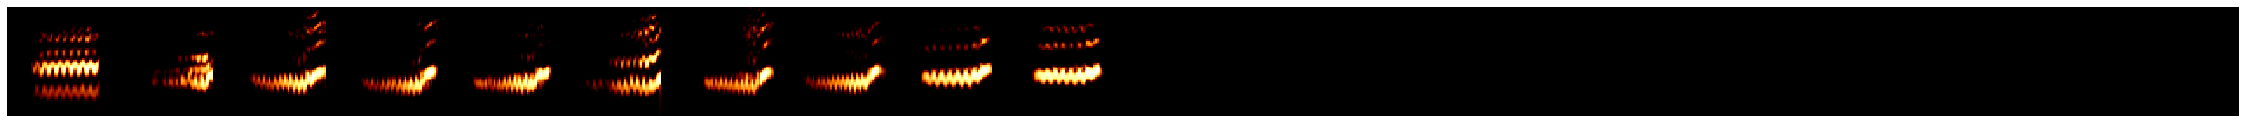

GBYM 15


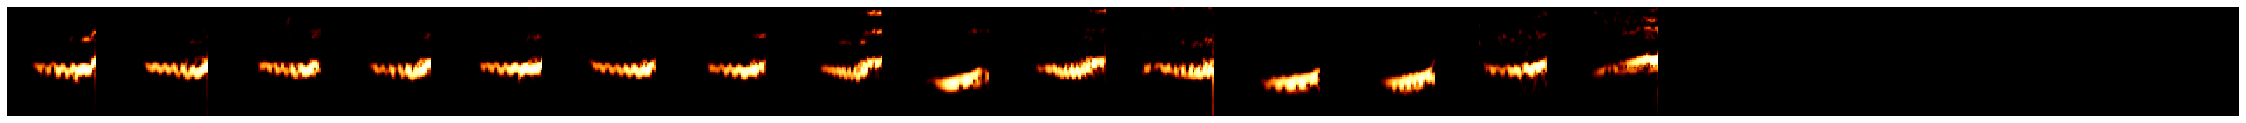

GON XF 19-21 2


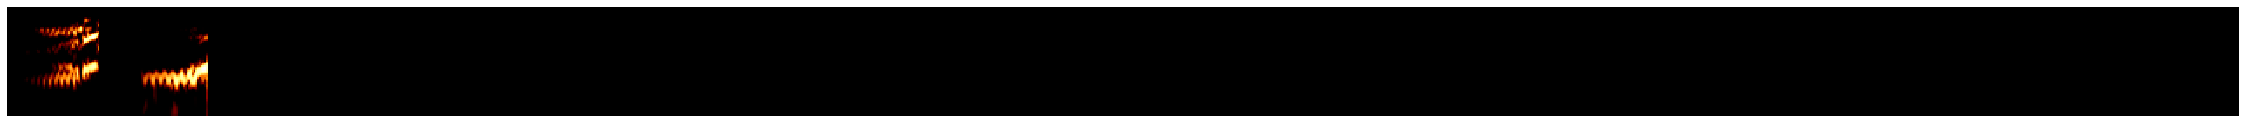

GON XM 20-21 3


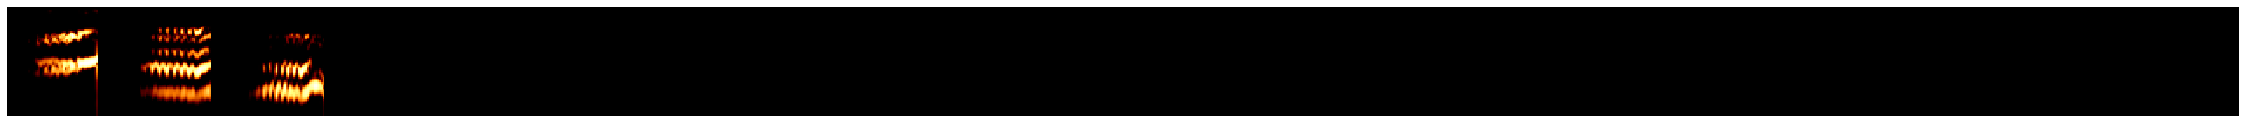

MGGY 7


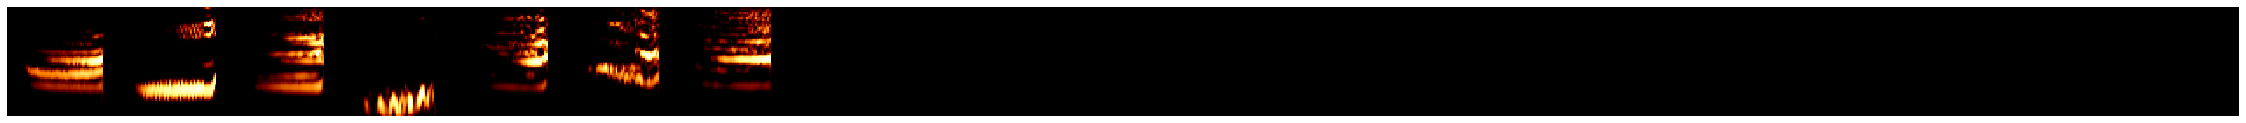

MOGO 18


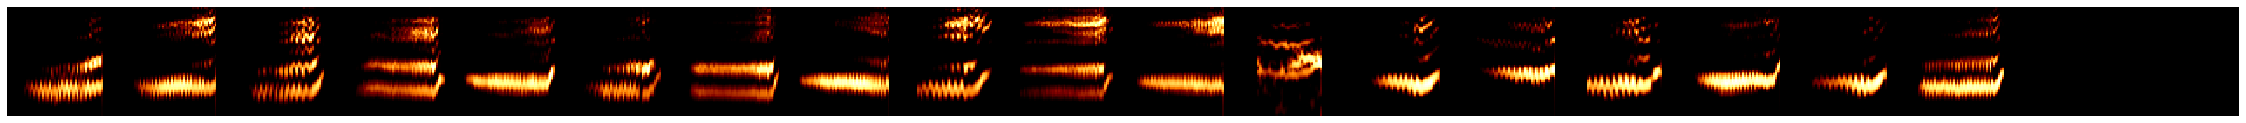

MOOO 1


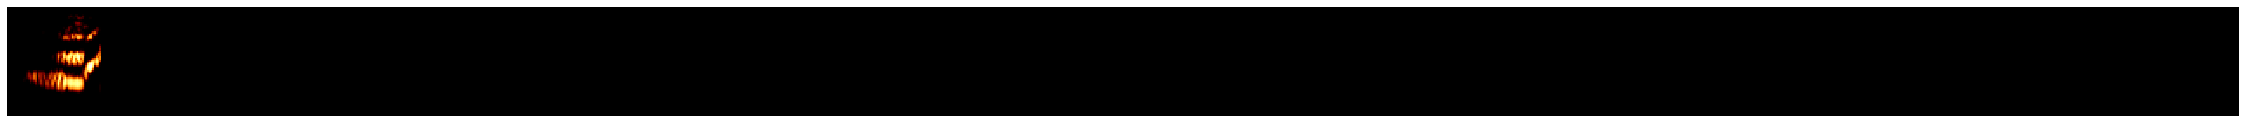

MORP 3


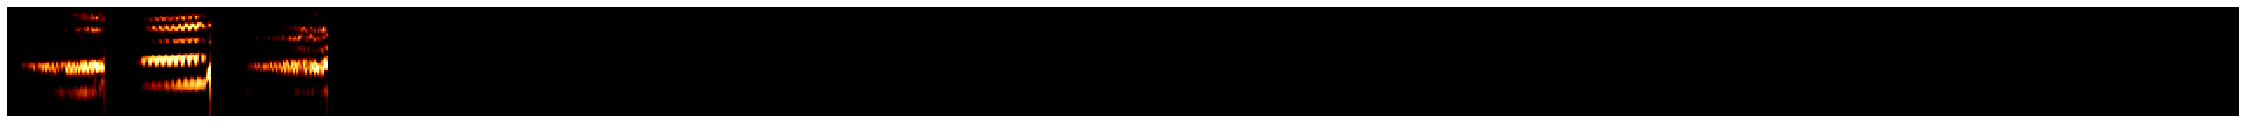

MOVY 5


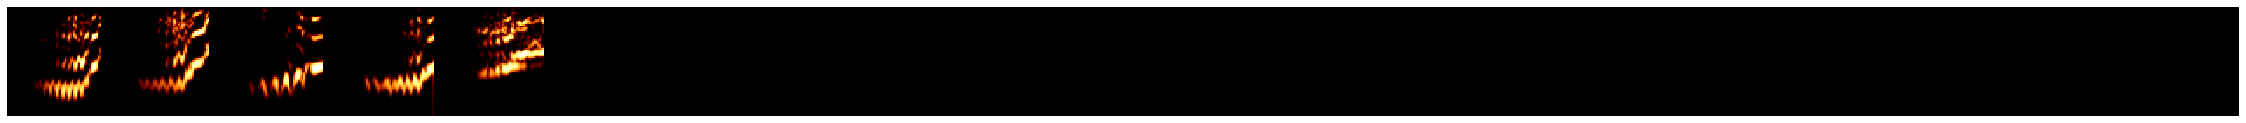

MRGO 10


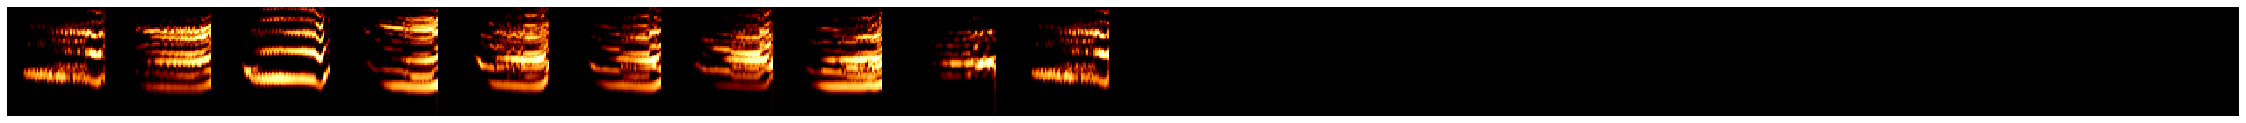

MXWW 9


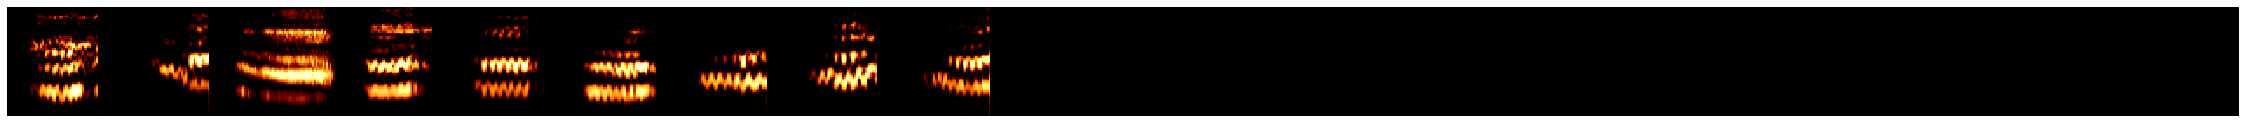

MXXBYX 2


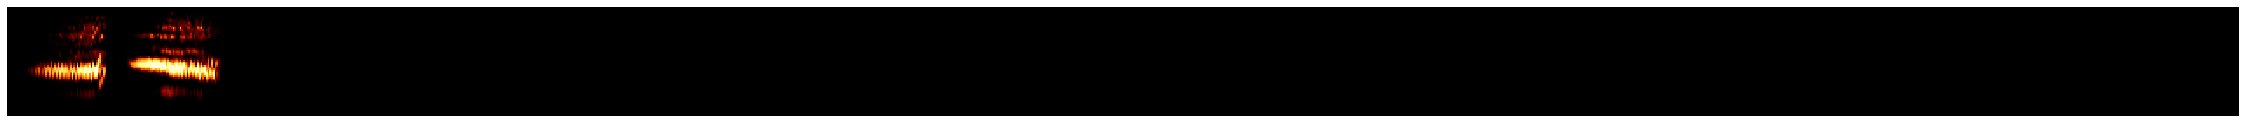

MXXGRY 11


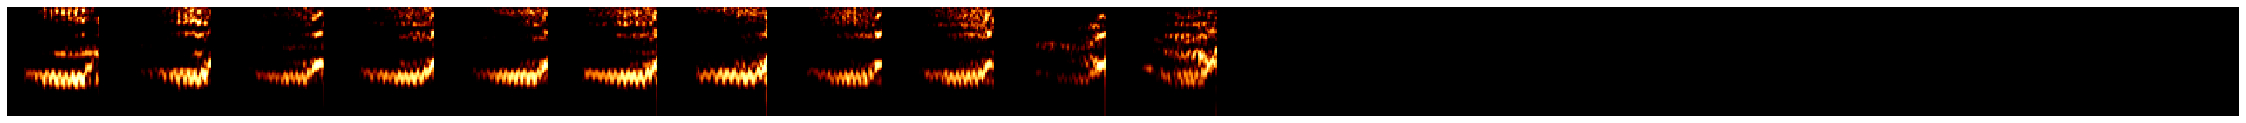

OMGO 11


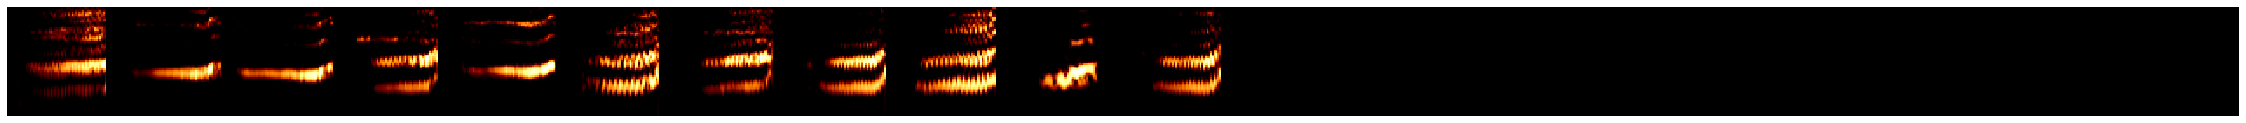

RMXGMX 19


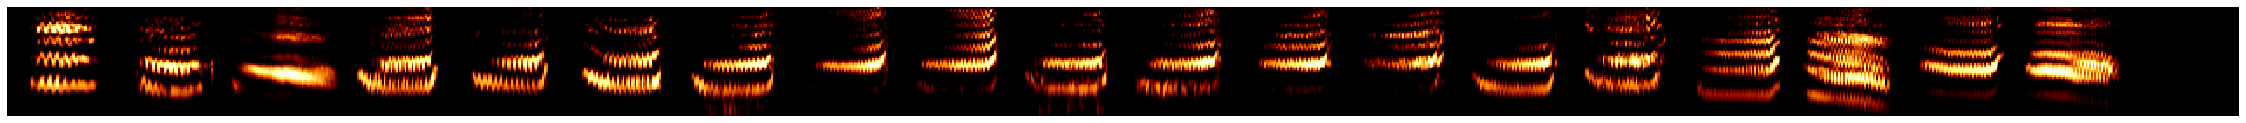

RMYG 7


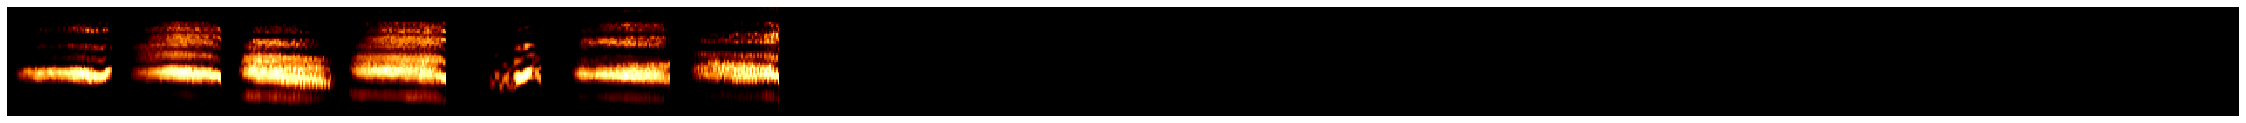

RYMR 1


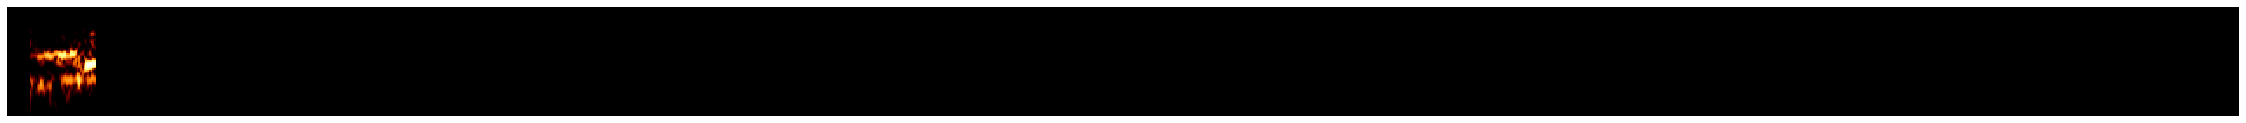

SCL XF 20-21 10


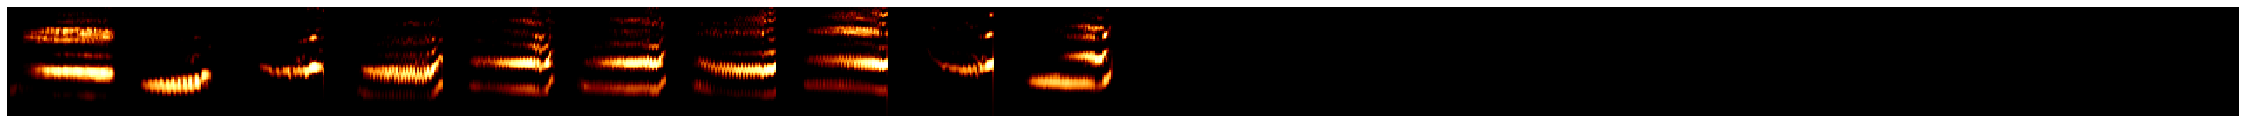

SCL XM 20-21 4


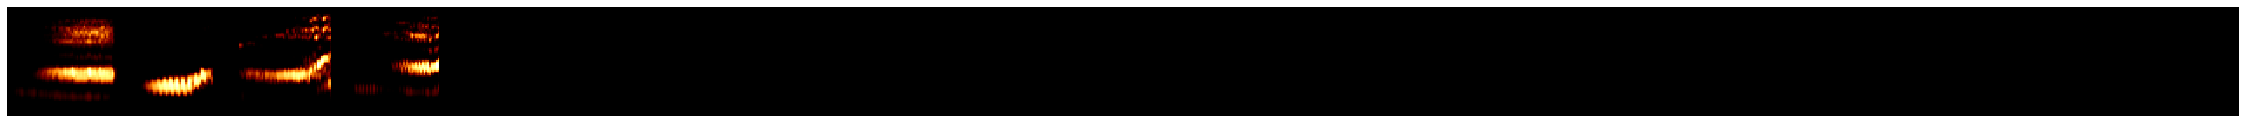

VVOM 1


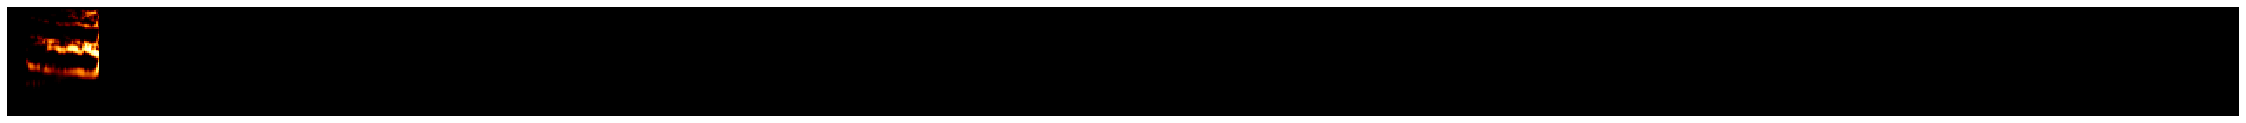

VVVM 22


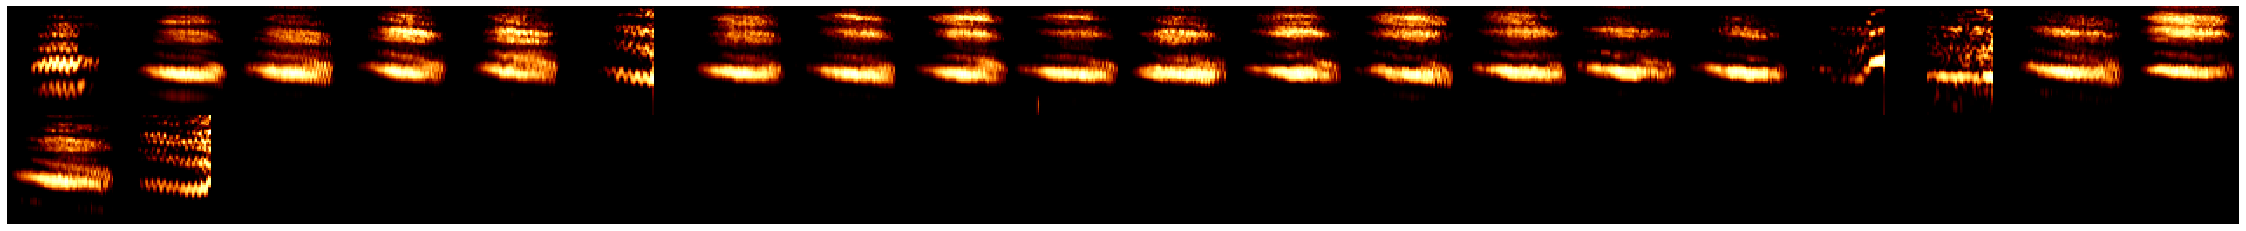

XF 20-21 2


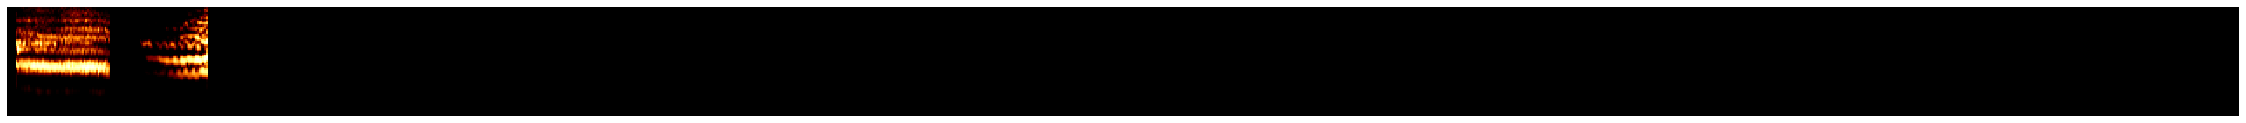

In [17]:
for indv in np.sort(seg_df.indv.unique()[:]):
    print(indv, np.sum(seg_df.indv == indv))
    specs = np.array([i/np.max(i) for i in seg_df[seg_df.indv == indv].specs.values])
    specs[specs<0] = 0
    
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [18]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [20]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [21]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/173 [00:00<?, ?it/s]

(173, 4096)

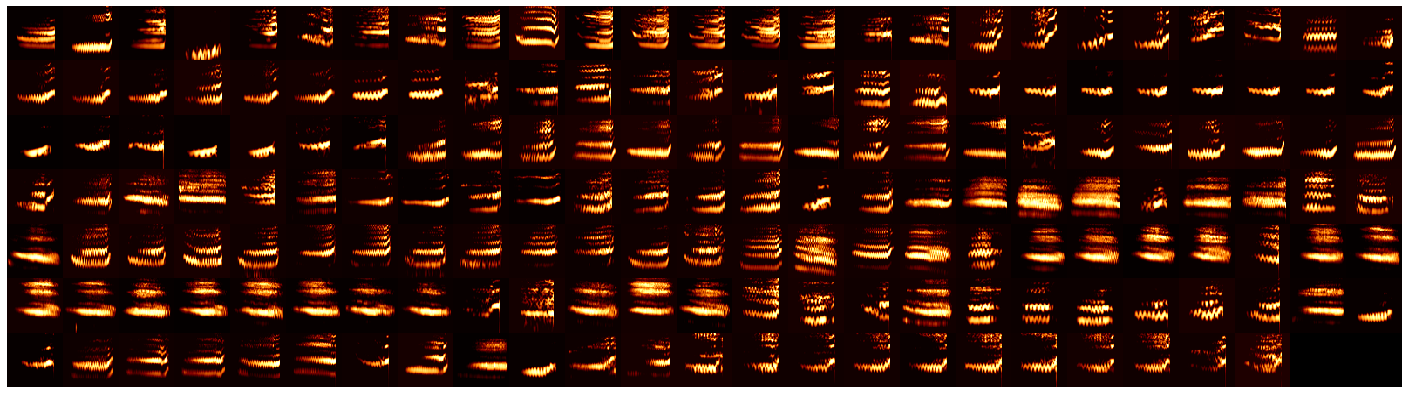

In [22]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [22]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 16 15:28:42 2022 Finding Nearest Neighbors
Tue Aug 16 15:28:44 2022 Finished Nearest Neighbor Search
Tue Aug 16 15:28:46 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 16 15:28:47 2022 Finished embedding


In [38]:
#save df
save_loc = DATA_DIR / DATASET_ID / 'NL' /  'NL.pickle'
ensure_dir(save_loc.as_posix())
seg_df.to_pickle(save_loc)